## Description 
This notebook contains a basic implementation of a Keras UNet model for the [Sartorius - Cell Instance Segmentation competition](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/data). It is also my final project for CS5600 - Inteligent Systems at Utah State University. 

## Problem definition
Data: 

[Phase-contrast microscopy](https://en.wikipedia.org/wiki/Phase-contrast_microscopy) images of human neuronal cell  along with annotations (labels) representing cell segmentations. 

Aim: 

The trained model should be able to predict the annotations for cell segmentation, including rare cell types (such as neuroblastoma cell line SH-SY5Y as discussed in the [competition description](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview)). Annotations should be provided in run-length format (see functions rle_decode() and rle_encode below).

## Approach 
[U-Net](https://en.wikipedia.org/wiki/U-Net) as implemented in reference notebook 2. 

"The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - MobileNetV2 - as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo. (Check out the pix2pix: Image-to-image translation with a conditional GAN tutorial in a notebook.)

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples." [Tensorflow Tutorials: Image segmentation ](https://www.tensorflow.org/tutorials/images/segmentation).  

Reference notebooks:
1. [Sartorius Competition Training Keras UNet](https://www.kaggle.com/aramos/sartorius-competition-training-keras-unet).

Other references: 
1. [Tensorflow Tutorials: Image segmentation ](https://www.tensorflow.org/tutorials/images/segmentation).
2. [pix2pix: Image-to-image translation with a conditional GAN](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=nb).

## OUTPUT
The final output scored 0.442 on 

## Workflow

[1. Libraries and paths](#section-1)

[2. Functions](#section-2)

[3. Constants](#section-3)

[4. Generate train and validation data sets](#section-4)

[5. Define the model](#section-5)

[6. Training](#section-6)

[7. Test set predictions](#section-7)



<a id="section-1"></a>
### 1. Libraries and paths

In [26]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [27]:
# input
DIR = './sartorius-cell-instance-segmentation'
train_csv = os.path.join(DIR,'train.csv') 
train_path =  os.path.join(DIR, 'train/')
test_path = os.path.join(DIR, 'test/')

# model path
model_load_path = os.path.join('./', 'unet_keras_model.h5')

# output 
OUTPUT = './output'
csv_output = os.path.join(OUTPUT, 'submission.csv') 
model_output = os.path.join(OUTPUT, 'unet_keras_model.h5')
base_model_path = os.path.join(OUTPUT, 'base_keras_model.h5')

<a id="section-2"></a>
### 2. Functions

In [28]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background.
    ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    ref: https://www.kaggle.com/dragonzhang/positive-score-with-detectron-3-3-inference
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def get_mask(image_id, df):
    '''
    Uses rle_decode() to get ndarray from mask using image_id in dataframe (df).
    ref: https://www.kaggle.com/barteksadlej123/sartors-tf-starter
    '''
    current = df[df["id"] == image_id]
    labels = current["annotation"].tolist()
    
    mask = np.zeros((HEIGHT, WIDTH))
    for label in labels:
        mask += rle_decode(label, (HEIGHT, WIDTH))
    mask = mask.clip(0, 1)
    
    return mask


#  fix overlaps: 
def check_overlap(msk):
    '''
    Checks if there are overlap in a mask (msk).
    ref: https://www.kaggle.com/awsaf49/sartorius-fix-overlap
    '''
    msk = msk.astype(np.bool).astype(np.uint8)
    return np.any(np.sum(msk, axis=-1)>1)


def fix_overlap(msk):
    '''
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None) 
    ref: https://www.kaggle.com/awsaf49/sartorius-fix-overlap
    '''
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk


# make predictions for test set: 
def make_predictions(dataset, num, keras_model):
    '''
    For a tf.Dataset, makes predictions for n=num (num =-1 or all_images takes all images in the dataset), 
    images using a keras_model. Returns a list of predicted masks, each as ndarray. 
    '''
    predictions = []
    if dataset:
        for image in dataset.take(num):
            image = image[None]
            pred_mask = keras_model.predict(image)
            # changes shape from (1,512,512,1) to (512,512)
            pred_mask = pred_mask[0, :, :, 0]
            # fix overlaps
            if check_overlap(msk=pred_mask)==True:
                pred_mask = pred_mask[None]
                pred_mask = fix_overlap(msk=pred_mask)
            # transforms ndarray values to 0s and 1s
            pred_mask =  np.where( pred_mask > 0.5, 1, 0)
            predictions.append(pred_mask)
    return predictions

<a id="section-3"></a>
### 3. Constants 

In [29]:
DEBUG = False

SEED = 666
WIDTH, HEIGHT = 704, 520
RESIZE_WIDTH, RESIZE_HEIGHT = 512, 512
BATCH_SIZE = 128
BUFFER_SIZE = 32

VAL_SPLIT = 0.2

AUTO = tf.data.AUTOTUNE

EPOCHS = 30

LOAD_PREVIOUS = False
TRAIN = True

<a id="section-4"></a>
### 4. Generate train and validation data sets

In [30]:
# train and validation split
train = pd.read_csv(train_csv)
train.head()

n_ids = train.id.nunique()

if DEBUG:
    unique_ids_train = list(set(train['id'].tolist()))[:BATCH_SIZE]
    unique_ids_valid = list(set(train['id'].tolist()))[BATCH_SIZE:2*BATCH_SIZE]
else:
    unique_ids_train = list(set(train['id'].tolist()))[:int(n_ids * (1 - VAL_SPLIT))]
    unique_ids_valid = list(set(train['id'].tolist()))[int(n_ids * (1 - VAL_SPLIT)):]


temp = pd.DataFrame()
for sample_id in unique_ids_train:
    query = train[train.id == sample_id]
    temp = pd.concat([temp, query])
train = temp
train = train.reset_index(drop=True)

temp = pd.DataFrame()
for sample_id in unique_ids_valid:
    query = train[train.id == sample_id]
    temp = pd.concat([temp, query])
valid = temp
valid = train.reset_index(drop=True)
    
TRAIN_LENGTH = train['id'].nunique()
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VALID_LENGTH = valid['id'].nunique()
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE

# training data generator 
def train_generator(df):
    image_ids = set(df['id'].tolist())
    
    for image_id in image_ids:
        image = cv2.imread(os.path.join(train_path, image_id) + '.png') 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = get_mask(image_id, df)
        
        image = cv2.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))
        mask = cv2.resize(mask, (RESIZE_HEIGHT, RESIZE_WIDTH))
        mask = mask.reshape((*mask.shape, 1))
        
        image = image.astype(np.float32)
        mask = mask.astype(np.int32)
        
        yield image, mask
        
# use the generator to get training and validation sets
train_ds = tf.data.Dataset.from_generator(
    lambda : train_generator(train), 
    output_types=(tf.float32, tf.int32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3), (RESIZE_HEIGHT, RESIZE_WIDTH, 1)))

valid_ds = tf.data.Dataset.from_generator(
    lambda : train_generator(valid), 
    output_types=(tf.float32, tf.int32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3), (RESIZE_HEIGHT, RESIZE_WIDTH, 1)))

# "the following class performs a simple augmentation by randomly-flipping an image"
class Augment(keras.layers.Layer):
    def __init__(self, seed=SEED):
        super().__init__()
        
        self.augment_inputs = preprocessing.RandomFlip('horizontal', seed=seed)
        self.augment_labels = preprocessing.RandomFlip('horizontal', seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels
    
# "build the input pipeline, applying the augmentation after batching the inputs"
train_ds = (
    train_ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(AUTO)
)

valid_ds = (
    valid_ds
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)

<a id="section-5"></a>
### 5. Define the model 

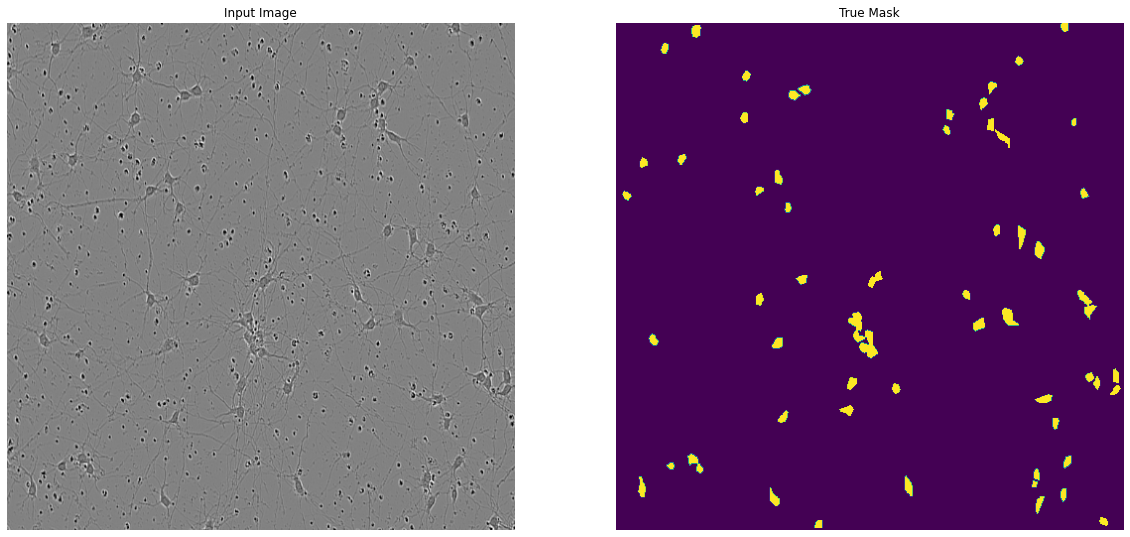

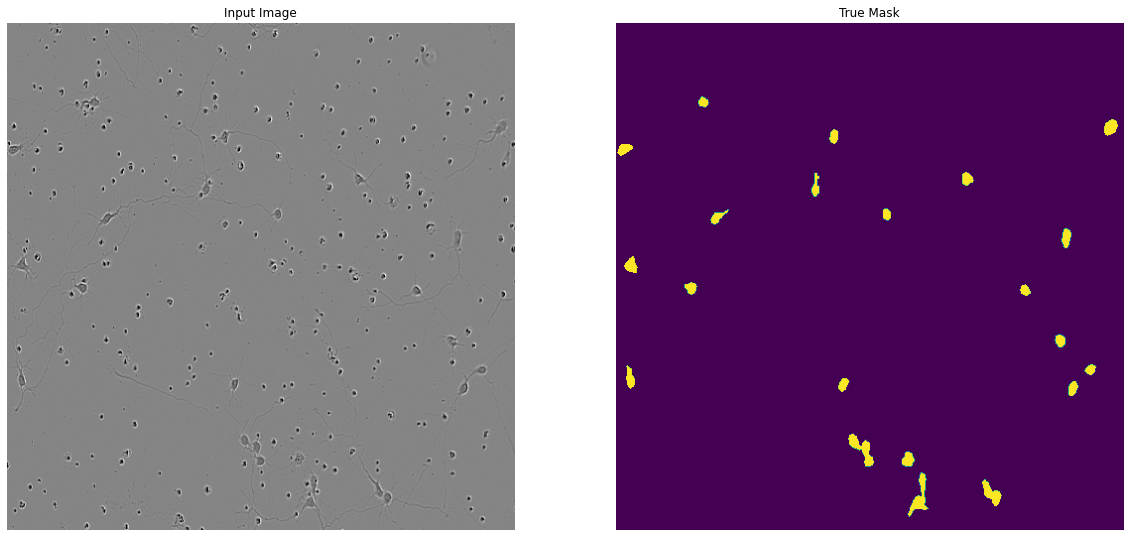

In [31]:
# "visualize an image example and its corresponding mask from the dataset"

def display(display_list):
    plt.figure(figsize=(20, 20))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for images, masks in train_ds.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

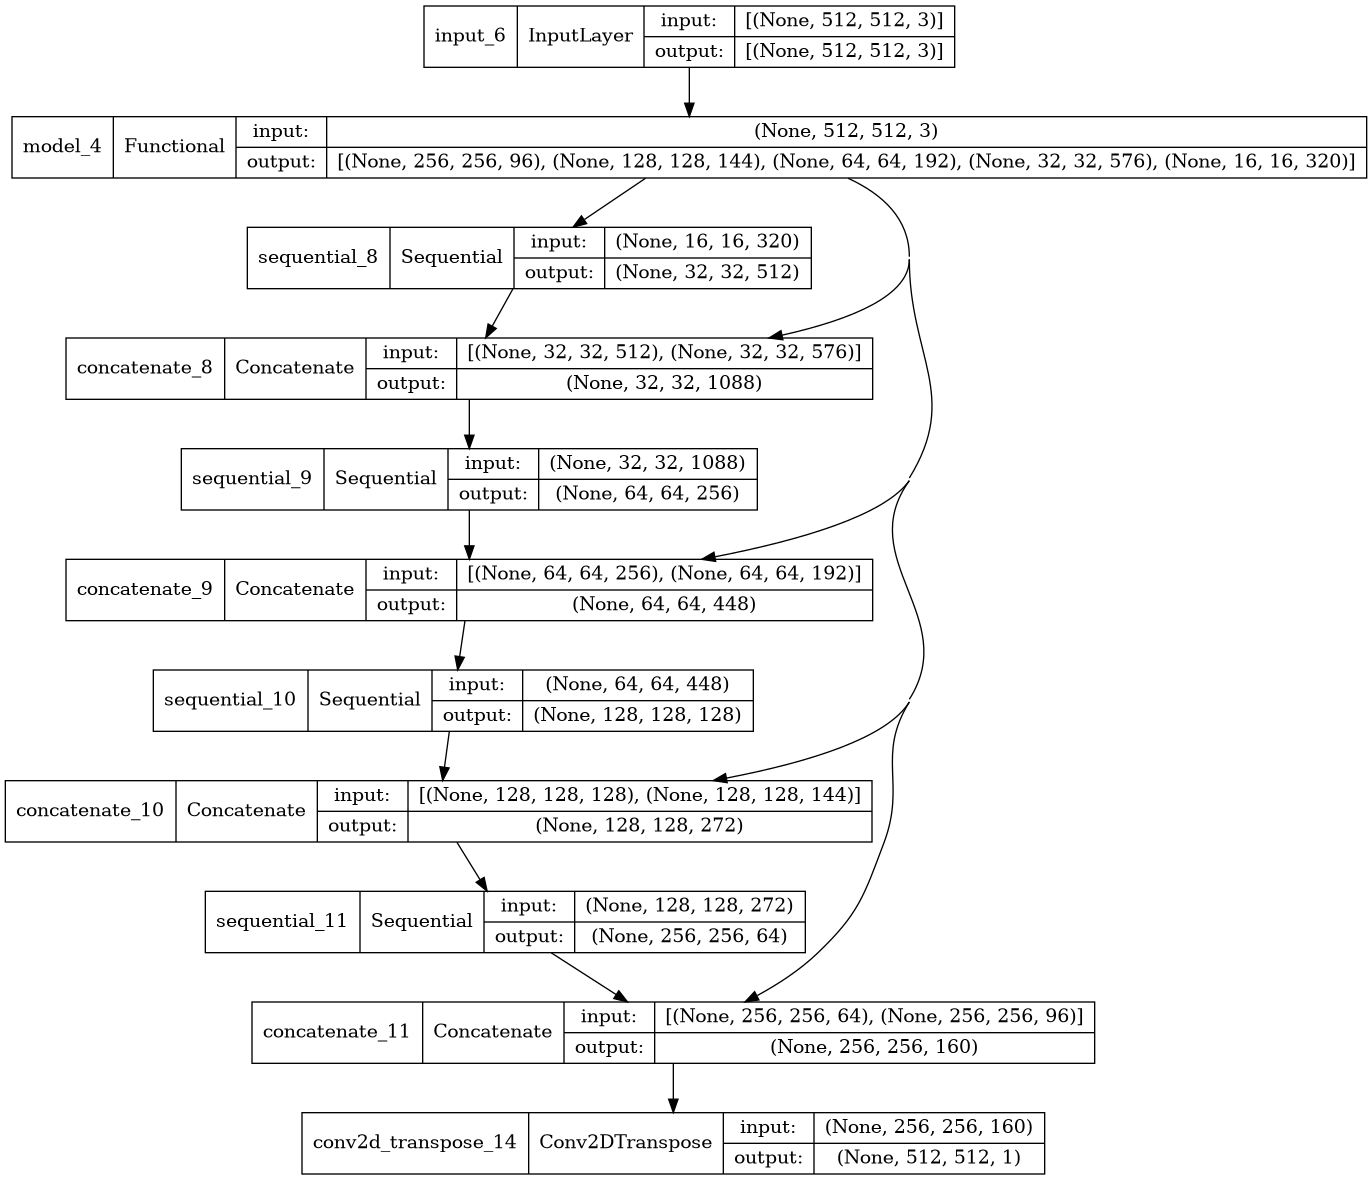

In [32]:
def gen_new_model():
    # base model and encoder (down_stack)
    base_model = keras.applications.MobileNetV2(input_shape=[RESIZE_HEIGHT, RESIZE_WIDTH, 3], include_top=False)


    # use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # create the feature extraction model
    down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    down_stack.trainable = False

    # decoder / upsampler

    def upsample(filters, size, apply_dropout=False):
        '''
        filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution). 
        size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
        Can be a single integer to specify the same value for all spatial dimensions. 
        return: 4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' 
        or 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last
        ref: https://www.tensorflow.org/tutorials/generative/pix2pix?hl=nb
        '''
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(keras.layers.Conv2DTranspose(
            filters, 
            size, 
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False))
        result.add(keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(keras.layers.Dropout(0.5))
        result.add(keras.layers.ReLU())
        return result


    up_stack = [
        upsample(512, 3),  # 4x4 -> 8x8
        upsample(256, 3),  # 8x8 -> 16x16
        upsample(128, 3),  # 16x16 -> 32x32
        upsample(64, 3),   # 32x32 -> 64x64
    ]

    # U-Net model 
    def unet_model(output_channels=1):
        inputs = keras.layers.Input(shape=[RESIZE_HEIGHT , RESIZE_WIDTH, 3])
        # "downsampling through the model"
        skips = down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])
        # "sampling and establishing the skip connections"
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = keras.layers.Concatenate()
            x = concat([x, skip])
        # "this is the last layer of the model"
        last = keras.layers.Conv2DTranspose(
            filters=output_channels, 
            kernel_size=3, 
            strides=2,
            padding='same', 
            activation='sigmoid',
        ) #64x64 -> 128x128

        x = last(x)

        return keras.Model(inputs=inputs, outputs=x)

    # compile model 

    model = unet_model()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            'accuracy', 
            keras.metrics.MeanIoU(num_classes=2),
        ],
    )

    return model

model = (keras.models.load_model(model_load_path) 
    if LOAD_PREVIOUS 
    else gen_new_model())

# visualize model architecture 
keras.utils.plot_model(model, show_shapes=True)

(128, 512, 512, 1)


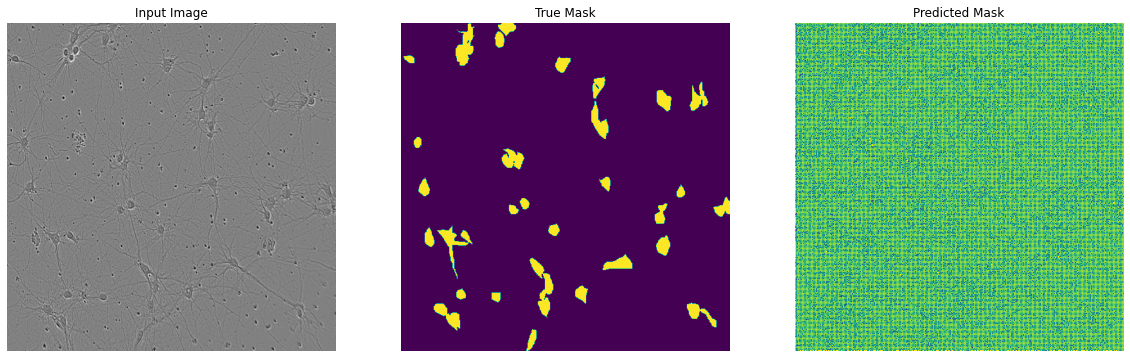

(128, 512, 512, 1)


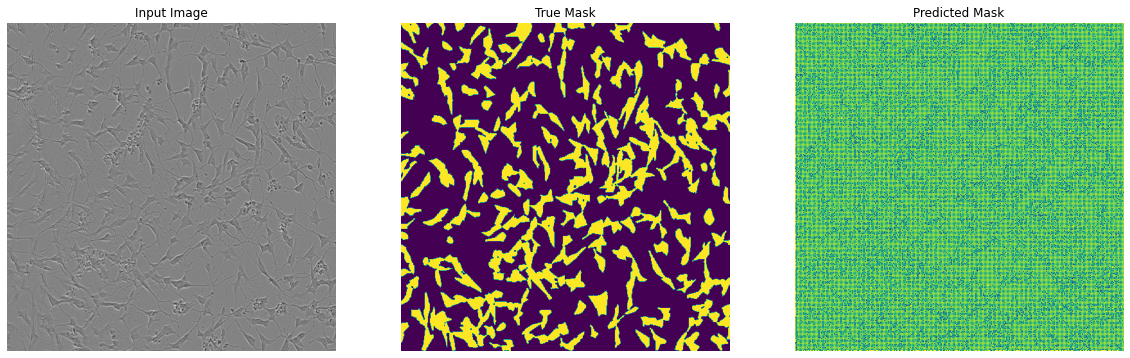

In [33]:
# try out the model to check what it predicts before training
def create_mask(pred_mask):
    pred_mask = tf.where(pred_mask > 0.5, 1, 0)
    return pred_mask


def show_predictions(dataset=None, num=3):
    if dataset:
        for image, mask in dataset.take(num):
            t = model.predict(image)
            print(t.shape)
            display([
                image[0], 
                mask[0], 
                create_mask(t[0])
            ])
    else:
        display([
            sample_image, 
            sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...])[0])
        ])

        
show_predictions(train_ds)

<a id="section-6"></a>
### 6. Training

In [34]:
# training

# "observe how the model improves while it is training"
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=False)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

if TRAIN:
    model_history = model.fit(
        train_ds, 
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        validation_data=valid_ds,
        callbacks=[
            DisplayCallback(),
            keras.callbacks.ModelCheckpoint(
                model_output,
                save_best_only=True,
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.1, 
                patience=10, 
                verbose=0,
                mode='auto', 
                min_delta=0.00001, 
                cooldown=0, 
                min_lr=0.00001
            ),
        ],
    )

Epoch 1/30


In [ ]:
# plot training curve
if TRAIN:
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    plt.figure()
    plt.plot(model_history.epoch, loss, 'r', label='Training loss')
    plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

<a id="section-7"></a>
### 7. Test set predictions

In [ ]:
# test data generator 
test_ids = [os.path.join(test_path, each) for each in os.listdir(test_path) if each.endswith('.png')]
def test_generator(image_ids):
    for image_id in image_ids:
        image = cv2.imread(image_id) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        image = cv2.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))
        image = image.astype(np.float32)
        yield image

# test dataset from test data generator 
test_ds = tf.data.Dataset.from_generator(
    lambda: test_generator(test_ids), 
    output_types=(tf.float32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3)) 
)

# test image ids and predictions
test_predictions = make_predictions(dataset=test_ds, num=len(test_ids), keras_model=model)

# encode predections in the RL format
test_predictions = [rle_encode(mask) for mask in test_predictions] 

# transform full image paths to ids 
test_ids = [Path(ID).stem for ID in test_ids]

# generate submission data frame 
submisssion = pd.DataFrame.from_dict({'id': test_ids, 'predicted': test_predictions} )
submisssion = submisssion.sort_values(['id'], ascending=True )
print(submisssion.head(), 'n')
submisssion.to_csv(csv_output, index=False)